## Summary Notebook of SubSpaCECF method, all in one hand ;)

Pre-requisites: 
- recommended: set up virtual environment (PowerShell: python -m venv venv ) & activate it (venv\Scripts\activate)
- recomended: install requirements.txt (pip install -r requirements.txt)
- used python version: 3.12.5

#### Input
- UCR Datasets

#### Output 
- FCN Model for UCR Data 
- generated Counterfactuals 
- metrics for evaluating counterfactuals <-those could be compared to Quantus results

In [145]:
# pip install liac-arff
# pip install tslearn

In [190]:
# imports 

import arff
from abc import ABC, abstractmethod  # For abstract classes and methods
import copy  # For deep and shallow copying of objects
import numpy as np  # For numerical computations and array operations
import pandas as pd  # For data manipulation and analysis
import pickle  # For serializing and deserializing objects
import random  # For random operations
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels
from tensorflow import keras  # For building and training neural networks
import tensorflow as tf  # For machine learning and deep learning
from tqdm import tqdm  # For progress bars in loops
from tslearn.neighbors import KNeighborsTimeSeries  # For K-Nearest Neighbors with time series data
from multiprocessing import Pool  # For parallel processing
import os
import time


import requests
import zipfile
from matplotlib import pyplot as p

## Define functions

In [147]:
# this is replacing the local_data_loader function in the original code 
def download_and_extract_ucr(dataset_name, base_url="https://timeseriesclassification.com/aeon-toolkit/"):
    # Create a directory for the dataset
    if not os.path.exists(dataset_name):
        os.makedirs(dataset_name)
    
    # Construct the URL and local file path
    url = f"{base_url}{dataset_name}.zip"
    zip_path = f"{dataset_name}/{dataset_name}.zip"
    
    # Download the dataset
    print(f"Downloading {dataset_name}...")
    response = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(response.content)
    
    # Extract the dataset
    print(f"Extracting {dataset_name}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(dataset_name)
    
    # Remove the zip file
    os.remove(zip_path)
    print(f"{dataset_name} is ready.")

def load_ucr_dataset(dataset_name):
    # Load the training data from the ARFF file
    train_file = f"{dataset_name}/{dataset_name}_TRAIN.arff"
    with open(train_file, 'r', encoding='utf-8', errors='ignore') as f:
        train_data = arff.load(f)
    train_data = np.array(train_data['data'])

    # Load the test data from the ARFF file
    test_file = f"{dataset_name}/{dataset_name}_TEST.arff"
    with open(test_file, 'r', encoding='utf-8', errors='ignore') as f:
        test_data = arff.load(f)
    test_data = np.array(test_data['data'])
    
    # Separate features and labels
    X_train = train_data[:, :-1].astype(float)
    y_train = train_data[:, -1].astype(int)
    X_test = test_data[:, :-1].astype(float)
    y_test = test_data[:, -1].astype(int)
    
    return X_train, y_train, X_test, y_test

In [148]:
# replacing categorial values in data with numerical
def label_encoder(training_labels, testing_labels):
    le = LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)
    return y_train, y_test

In [149]:
# used to find the nearest neighbors of a query time series that belong to a different class than the predicted class
def nun_retrieval(query, predicted_label, distance, n_neighbors, X_train, y_train):
    df = pd.DataFrame(y_train, columns=['label'])
    df.index.name = 'index'

    if isinstance(predicted_label, np.ndarray):
        predicted_label = predicted_label.item()
        
    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric=distance)
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    dist, ind = knn.kneighbors(np.expand_dims(query, axis=0), return_distance=True)
    distances = dist[0]
    index = df[df['label'] != predicted_label].index[ind[0][:]]
    label = df[df.index.isin(index.tolist())].values[0]
    return distances, index, label

In [183]:
# to store the results of the cf (including the creation of necessary folders)
def store_partial_cfs(results, s_start, s_end, Dataset, file_suffix_name):
    # Create folder for dataset if it does not exist
    os.makedirs(f'./results/{Dataset}/', exist_ok=True)
    with open(f'./results/{Dataset}/{file_suffix_name}_{s_start:04d}-{s_end:04d}.pickle', 'wb') as f:
        pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

In [151]:
def fitness_function_final(ms, predicted_probs, desired_class, outlier_scores,
                           invalid_penalization, alpha, beta, eta, gamma, sparsity_balancer):
    # Sparsity calculator
    ones_pct = ms.sum(axis=(1, 2)) / (ms.shape[1] * ms.shape[2])
    # subsequences = np.count_nonzero(np.diff(ms, prepend=0) == 1, axis=1)
    subsequences = np.count_nonzero(np.diff(ms, prepend=0, axis=1) == 1, axis=(1, 2))
    subsequences_pct = subsequences / ((ms.shape[1] // 2) * ms.shape[2])
    sparsity_term = sparsity_balancer * ones_pct + (1 - sparsity_balancer) * subsequences_pct ** gamma

    # Penalization for not prob satisfied
    desired_class_probs = predicted_probs[:, desired_class]
    predicted_classes = np.argmax(predicted_probs, axis=1)
    penalization = (predicted_classes != desired_class).astype(int)

    # Clip outlier scores
    outlier_scores[outlier_scores < 0] = 0

    # Calculate fitness
    fit = alpha * desired_class_probs - beta * sparsity_term - eta * outlier_scores - penalization * invalid_penalization

    return fit, desired_class_probs

In [184]:
def get_counterfactual_worker(sample_dict):
    Dataset = sample_dict["Dataset"]
    exp_name = sample_dict["exp_name"]
    params = sample_dict["params"]
    first_sample_i = sample_dict["first_sample_i"]
    x_orig_samples_worker = sample_dict["x_orig_samples"]
    nun_examples_worker = sample_dict["nun_examples"]
    desired_targets_worker = sample_dict["desired_targets"]

    # Get model
    model_worker = keras.models.load_model(r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\ECG200_ae.keras')

    # Get outlier calculator
    with open(f'{Dataset}_outlier_calculator.pickle', 'rb') as f:
        outlier_calculator_worker = pickle.load(f)

    # Instantiate the Counterfactual Explanation method
    cf_explainer = SubSpaCECF(model_worker, 'tf', outlier_calculator_worker, **params)

    # Generate counterfactuals
    results = []
    for i in tqdm(range(0, len(x_orig_samples_worker), 1)):
        x_orig_worker = x_orig_samples_worker[i]
        nun_example_worker = nun_examples_worker[i]
        desired_target_worker = desired_targets_worker[i]
        result = cf_explainer.generate_counterfactual(x_orig_worker, desired_target_worker, nun_example=nun_example_worker)
        results.append(result)

    # Store results of cf in list
    store_partial_cfs(results, first_sample_i, first_sample_i+THREAD_SAMPLES-1,
                      Dataset, file_suffix_name=exp_name)
    return 1

In [222]:
def experiment_dataset(Dataset, exp_name, params):
    # Load model
    model = keras.models.load_model(r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\ECG200_ae.keras')
    print('Model loaded successfully')

    # Predict on X_test
    y_pred_logits = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_logits, axis=1)
    print('Predictions created successfully')

    # Get the NUNs
    nuns_idx = []
    desired_classes = []
    for instance_idx in range(len(X_test)):
        distances, indexes, labels = nun_retrieval(X_test[instance_idx], y_pred[instance_idx],
                                                   'euclidean', 1, X_train, y_train)
        nuns_idx.append(indexes[0])
        desired_classes.append(labels[0])
    nuns_idx = np.array(nuns_idx)
    desired_classes = np.array(desired_classes)
    print('Nuns created successfully')

    # Prepare dict to iterate over the optimization problem
    samples = []
    for i in range(I_START, len(X_test), THREAD_SAMPLES):
        # Initialize optimizer
        x_orig_samples = X_test[i:i + THREAD_SAMPLES]
        nun_examples = X_train[nuns_idx[i:i + THREAD_SAMPLES]]
        desired_targets = desired_classes[i:i + THREAD_SAMPLES]

        sample_dict = {
            "Dataset": Dataset,
            "exp_name": exp_name,
            "params": params,
            "first_sample_i": i,
            "x_orig_samples": x_orig_samples,
            "nun_examples": nun_examples,
            "desired_targets": desired_targets,
        }
        samples.append(sample_dict)
        print('Sample completed', i)

    # Execute counterfactual generation without multiprocessing
    print(f'Starting experiment {exp_name} for dataset {Dataset}...')
    for sample_dict in tqdm(samples, total=len(samples)):
        get_counterfactual_worker(sample_dict)

    # Concatenate the results
    print('Start concatenation')
    concatenate_result_files(Dataset, exp_name)
    print('Finished')

In [186]:
def experiment_dataset(Dataset, exp_name, params):
    # Load model
    model = keras.models.load_model(r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\ECG200_ae.keras')
    print('Model loaded successfully')

    # Predict on x test
    y_pred_logits = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_logits, axis=1)
    print('Predictions created successfully')

    # Get the NUNs
    nuns_idx = []
    desired_classes = []
    for instance_idx in range(len(X_test)):
        distances, indexes, labels = nun_retrieval(X_test[instance_idx], y_pred[instance_idx],
                                                   'euclidean', 1, X_train, y_train)
        nuns_idx.append(indexes[0])
        desired_classes.append(labels[0])
    nuns_idx = np.array(nuns_idx)
    desired_classes = np.array(desired_classes)
    print('Nuns created successfully')

    # START COUNTERFACTUAL GENERATION
    samples = []
    for i in range(I_START, len(X_test), THREAD_SAMPLES):
        # Init optimizer
        x_orig_samples = X_test[i:i + THREAD_SAMPLES]
        nun_examples = X_train[nuns_idx[i:i + THREAD_SAMPLES]]
        desired_targets = desired_classes[i:i + THREAD_SAMPLES]

        sample_dict = {
            "Dataset": Dataset,
            "exp_name": exp_name,
            "params": params,
            "first_sample_i": i,
            "x_orig_samples": x_orig_samples,
            "nun_examples": nun_examples,
            "desired_targets": desired_targets,
        }
        samples.append(sample_dict)
        print('Sample completed', i)

    # Statt multiprocessing: Führe get_counterfactual_worker für jedes Sample aus
    for sample_dict in tqdm(samples, total=len(samples)):
        get_counterfactual_worker(sample_dict)

    # Nach der Generierung der Counterfactuals: Ergebnisse zusammenführen
    print('start concatenation')
    concatenate_result_files(Dataset, exp_name)
    print('Finished')


In [187]:
def infer_fragmentation_samples(Dataset, prefix_files_name, path=r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\experiments'):
    dir_path = os.path.join(path, Dataset)
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"The directory {dir_path} does not exist.")
    
    files = [filename for filename in os.listdir(dir_path) if filename.startswith(prefix_files_name)]
    
    if not files:
        raise FileNotFoundError(f"No files starting with {prefix_files_name} found in {dir_path}.")
    files = [filename for filename in os.listdir(f'{path}\\{Dataset}') if filename.startswith(prefix_files_name)]
    last_file_name = files[-1]
    last_file_name = last_file_name.replace(prefix_files_name, "")
    last_file_name = last_file_name.replace(".pickle", "")
    last_file_name = last_file_name.replace("_", "")
    last_file_samples_range = last_file_name.split("-")
    start_index = int(last_file_samples_range[0])
    end_index = int(last_file_samples_range[1])

    fragmentation = end_index - start_index + 1
    total = end_index + 1

    return fragmentation, total


def concatenate_and_store_partial_results(Dataset, prefix_files_name, suffixes_list, path='.'):
    all_files_list = []
    for suffix in suffixes_list:
        with open(f'{path}/{Dataset}/{prefix_files_name}_{suffix}.pickle', 'rb') as f:
            part_file = pickle.load(f)

        all_files_list = all_files_list + part_file

    # Store concatenated file
    with open(f'{path}/{Dataset}/{prefix_files_name}.pickle', 'wb') as f:
        pickle.dump(all_files_list, f, pickle.HIGHEST_PROTOCOL)


def remove_partial_files(Dataset, prefix_files_name, path='.'):
    files = [filename for filename in os.listdir(f'{path}/{Dataset}') if filename.startswith(prefix_files_name)]
    partial_files = [filename for filename in files if '-' in filename]
    for partial_file in partial_files:
        os.remove(f'{path}/{Dataset}/{partial_file}')

def concatenate_result_files(Dataset, prefix_file_name):
    # Calculate suffixes to concatenate
    fragmentation_samples, total_samples = infer_fragmentation_samples(
        Dataset,
        prefix_file_name,
        path=r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\experiments\results'
    )
    suffixes_list = [f"{i:04d}-{i + fragmentation_samples - 1:04d}" for i in
                     range(0, total_samples, fragmentation_samples)]
    concatenate_and_store_partial_results(
        Dataset,
        prefix_file_name,
        suffixes_list,
        path=r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\\experiments\results'
    )
    # Remove the temporal files
    remove_partial_files(
        Dataset,
        prefix_file_name,
        path=r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\\experiments\results'
    )

In [173]:
path = r'C:\Users\vanes\Documents\DSB Master\Sub-SpaCE\.venv\experiments'

## Define classes

In [155]:
class AEOutlierCalculator:
    def __init__(self, ae_model, calibration_data):
        self.length = calibration_data.shape[1]
        self.n_channels = calibration_data.shape[2]
        self.ae_model = ae_model

        # Calibrate to get outlier score as a number between 0 and 1
        calibration_reconstruction_errors = self._get_reconst_errors(calibration_data)
        self.min_error = 0
        self.max_error = calibration_reconstruction_errors.max()

    def _get_reconst_errors(self, data):
        data = data.reshape(-1, self.length, self.n_channels)
        data_reconstruction = self.ae_model.predict(data, verbose=0)
        reconstruction_errors = np.mean(np.abs(data - data_reconstruction), axis=(1, 2))
        return reconstruction_errors

    def _scale_score(self, data):
        scaled_scores = (data - self.min_error) / (self.max_error - self.min_error)
        return scaled_scores

    def get_outlier_scores(self, data):
        data_reconstruction_errors = self._get_reconst_errors(data)
        scores = self._scale_score(data_reconstruction_errors).flatten()
        return scores

In [156]:
class EvolutionaryOptimizer(ABC):
    def __init__(self, fitness_func, prediction_func, population_size, elite_number, offsprings_number, max_iter,
                 init_pct, reinit,
                 invalid_penalization, alpha, beta, eta, gamma, sparsity_balancer,
                 feature_axis):
        # Asert elite numbers and replacement count do not surpass population size
        if elite_number + offsprings_number > population_size:
            raise ValueError('Elites and offsprings counts must not be greater than population size')
        # Assert valid offspring number
        if offsprings_number % 2 != 0:
            raise ValueError('Offspring number must be even')

        self.population_size = population_size
        self.elite_number = elite_number
        self.offsprings_number = offsprings_number
        self.rest_number = population_size - elite_number - offsprings_number

        self.fitness_func = fitness_func
        self.invalid_penalization = invalid_penalization
        self.alpha = alpha
        self.beta = beta
        self.eta = eta
        self.gamma = gamma
        self.sparsity_balancer = sparsity_balancer

        self.prediction_func = prediction_func
        self.max_iter = max_iter
        self.original_init_pct = init_pct

        self.feature_axis = feature_axis

        self.reinit = reinit

    @abstractmethod
    def init_population(self, importance_heatmap=None):
        pass

    def init(self, x_orig, nun_example, desired_class, model, outlier_calculator=None, importance_heatmap=None):
        self.x_orig = x_orig
        self.nun_example = nun_example
        self.desired_class = desired_class
        self.model = model
        self.outlier_calculator = outlier_calculator
        self.importance_heatmap = importance_heatmap
        self.init_pct = copy.deepcopy(self.original_init_pct)
        self.init_population(self.importance_heatmap)

        # Get dimensionality attributes
        if self.feature_axis == 2:
            self.n_features = x_orig.shape[1]
            self.ts_length = x_orig.shape[0]
        else:
            self.n_features = x_orig.shape[0]
            self.ts_length = x_orig.shape[1]

        # Compute initial outlier scores
        self.outlier_scores_orig = self.outlier_calculator.get_outlier_scores(self.x_orig)
        self.outlier_score_nun = self.outlier_calculator.get_outlier_scores(self.nun_example)

    def __call__(self):
        return self.optimize()

    @abstractmethod
    def mutate(self, sub_population):
        pass

    def get_single_crossover_mask(self, subpopulation):
        split_points = np.random.randint(0, subpopulation.shape[1], size=subpopulation.shape[0] // 2)
        mask = np.arange(subpopulation.shape[1]) < split_points[:, np.newaxis]
        return mask

    def produce_offsprings(self, subpopulation, number):
        # Put features as individual examples
        # Swap axis if features are in axis 2
        if self.feature_axis == 2:
            # Get sample population
            adapted_subpopulation = np.swapaxes(subpopulation, 2, 1)
        else:
            adapted_subpopulation = subpopulation
        adapted_number = number * self.n_features
        adapted_subpopulation = adapted_subpopulation.reshape(adapted_number, -1)

        # Generate random split points and create mask
        mask = self.get_single_crossover_mask(adapted_subpopulation)

        # Generate random matches
        matches = np.random.choice(np.arange(adapted_subpopulation.shape[0]), size=(adapted_subpopulation.shape[0] // 2, 2), replace=False)

        # Create the two partial offsprings
        offsprings1 = np.empty((adapted_number//2, adapted_subpopulation.shape[1]))
        offsprings1[mask] = adapted_subpopulation[matches[:, 0]][mask]
        offsprings1[~mask] = adapted_subpopulation[matches[:, 1]][~mask]
        offsprings2 = np.zeros((adapted_number//2, adapted_subpopulation.shape[1]))
        offsprings2[mask] = adapted_subpopulation[matches[:, 1]][mask]
        offsprings2[~mask] = adapted_subpopulation[matches[:, 0]][~mask]
        # Calculate adapted offspring
        adapted_offsprings = np.concatenate([offsprings1, offsprings2])

        # Mutate offsprings
        adapted_offsprings = self.mutate(adapted_offsprings)

        # Get final offsprings (matching original dimensionality)
        adapted_offsprings = adapted_offsprings.reshape(number, self.n_features, -1)
        if self.feature_axis == 2:
            offsprings = np.swapaxes(adapted_offsprings, 2, 1)
        else:
            offsprings = adapted_offsprings

        return offsprings

    @staticmethod
    def get_counterfactuals(x_orig, nun_example, population):
        population_mask = population.astype(bool)
        population_size = population.shape[0]
        # Replicate x_orig and nun_example in array
        x_orig_ext = np.tile(x_orig, (population_size, 1, 1))
        nun_ext = np.tile(nun_example, (population_size, 1, 1))
        # Generate counterfactuals
        counterfactuals = np.zeros(population_mask.shape)
        counterfactuals[~population_mask] = x_orig_ext[~population_mask]
        counterfactuals[population_mask] = nun_ext[population_mask]
        return counterfactuals

    def compute_fitness(self):
        # Get counterfactuals
        population_cfs = self.get_counterfactuals(self.x_orig, self.nun_example, self.population)

        # Get desired class probs
        predicted_probs = self.prediction_func(population_cfs)

        # Get outlier scores
        if self.outlier_calculator is not None:
            outlier_scores = self.outlier_calculator.get_outlier_scores(population_cfs)
            increase_outlier_score = outlier_scores - (self.outlier_scores_orig + self.outlier_score_nun) / 2
        else:
            outlier_scores = None
            increase_outlier_score = None

        # Get fitness function
        fitness, desired_class_probs = self.fitness_func(self.population, predicted_probs, self.desired_class, increase_outlier_score,
                                                         self.invalid_penalization, self.alpha, self.beta, self.eta,
                                                         self.gamma, self.sparsity_balancer)
        return fitness, desired_class_probs

    @staticmethod
    def roulette(fitness, number):
        scaled_fitness = (fitness - fitness.min()) / (fitness.max() - fitness.min() + 1e-5)
        selection_probs = scaled_fitness / scaled_fitness.sum()
        if np.isnan(selection_probs).any():
            print('NaN found in candidate probabilities')
            print(f'Fitness {fitness}')
            print(f'Selection probs: {selection_probs}')
        selected_indexes = np.random.choice(scaled_fitness.shape[0], number, p=selection_probs)
        return selected_indexes

    def select_candidates(self, population, fitness, number):
        selected_indexes = self.roulette(fitness, number)
        return population[selected_indexes]

    def optimize(self):
        # Keep track of the best solution
        best_score = -100
        best_sample = None
        best_classification_prob = 0
        fitness_evolution = []
        cf_evolution = []

        # Compute initial fitness
        fitness, _ = self.compute_fitness()
        i = np.argsort(fitness)[-1]
        fitness_evolution.append(fitness[i])
        best_cf = self.get_counterfactuals(self.x_orig, self.nun_example, np.expand_dims(self.population[i], axis=0))
        cf_evolution.append(np.squeeze(best_cf, axis=0))

        # Run evolution
        iteration = 0
        while iteration < self.max_iter:

            # Init new population
            new_population = np.empty(self.population.shape)

            # Elites: Select elites and add to new population
            elites_idx = np.argsort(fitness)[-self.elite_number:]
            new_population[:self.elite_number, :] = self.population[elites_idx]

            # Cross-over and mutation
            # Select parents
            candidate_population = self.select_candidates(self.population, fitness, self.offsprings_number)
            # Produce offsprings
            offsprings = self.produce_offsprings(candidate_population, self.offsprings_number)
            # Add to the population
            new_population[self.elite_number:self.offsprings_number + self.elite_number] = offsprings

            # The rest of the population is random selected
            random_indexes = np.random.randint(self.population_size, size=self.rest_number)
            if self.rest_number > 0:
                new_population[-self.rest_number:] = self.population[random_indexes]

            # Change population
            self.population = new_population.astype(int)
            # Keep track of the best solution
            if len(self.population) < self.population_size:
                print('what???')
            fitness, class_probs = self.compute_fitness()
            i = np.argsort(fitness)[-1]
            fitness_evolution.append(fitness[i])
            best_cf = self.get_counterfactuals(self.x_orig, self.nun_example, np.expand_dims(self.population[i], axis=0))
            cf_evolution.append(np.squeeze(best_cf, axis=0))
            if fitness[i] > best_score:
                best_score = fitness[i]
                best_sample = self.population[i]
                best_classification_prob = class_probs[i]

            # Handle while loop updates
            if self.reinit and (iteration == 50) and (self.init_pct < 1) and (fitness[i] < -self.invalid_penalization+1):
                print('Failed to find a valid counterfactual in 50 iterations. '
                      'Restarting process with more activations in init')
                iteration = 0
                self.init_pct = self.init_pct + 0.2
                self.init_population(self.importance_heatmap)
                fitness, class_probs = self.compute_fitness()
            else:
                iteration += 1

            # Reinit if all fitness are equal
            if np.all(fitness == fitness[0]):
                print(f'Found convergence of solutions in {iteration} iteration. Final prob {best_classification_prob}')
                if best_classification_prob > 0.5:
                    break
                else:
                    iteration = 0
                    self.init_pct = self.init_pct + 0.2
                    self.init_population(self.importance_heatmap)
                    fitness, class_probs = self.compute_fitness()

        return best_sample, best_classification_prob, fitness_evolution, cf_evolution


class BasicEvolutionaryOptimizer(EvolutionaryOptimizer):
    def __init__(self, fitness_func, prediction_func,
                 population_size=100, elite_number=4, offsprings_number=96, max_iter=100,
                 mutation_prob=0.1,
                 init_pct=0.4, reinit=True,
                 invalid_penalization=100, alpha=0.2, beta=0.6, eta=0.2, gamma=0.25, sparsity_balancer=0.4,
                 feature_axis=2):
        super().__init__(fitness_func, prediction_func, population_size, elite_number, offsprings_number, max_iter,
                         init_pct, reinit,
                         invalid_penalization, alpha, beta, eta, gamma, sparsity_balancer, feature_axis)
        self.mutation_prob = mutation_prob

    def init_population(self, importance_heatmap=None):
        # Init population
        random_data = np.random.uniform(0, 1, (self.population_size,) + self.x_orig.shape)
        if importance_heatmap is not None:
            mix_ratio = 0.6
            inducted_data = (mix_ratio * random_data + (1 - mix_ratio) * importance_heatmap) / 2
        else:
            inducted_data = random_data
        # Calculate quantile and population
        quantile_80 = np.quantile(inducted_data.flatten(), 1 - self.init_pct)
        self.population = (inducted_data > quantile_80).astype(int)

    def crossover(self, x1, x2):
        # Choose a random crossover point
        p = random.randint(0, x1.shape[0])

        # Compute offspring
        x_off_1 = np.concatenate((x1[:p], x2[p:]), axis=0)
        x_off_2 = np.concatenate((x2[:p], x1[p:]), axis=0)
        return x_off_1, x_off_2

    def mutate(self, sub_population):
        # Compute mutation values
        mutation_mask = (np.random.uniform(0, 1, sub_population.shape) > 1-self.mutation_prob).astype(int)
        mutated_sub_population = (sub_population + mutation_mask) % 2
        return mutated_sub_population


class NSubsequenceEvolutionaryOptimizer(EvolutionaryOptimizer):

    def __init__(self, fitness_func, prediction_func,
                 population_size=100, elite_number=4, offsprings_number=96, max_iter=100,
                 change_subseq_mutation_prob=0.05, add_subseq_mutation_prob=0,
                 init_pct=0.4, reinit=True,
                 invalid_penalization=100, alpha=0.2, beta=0.6, eta=0.2, gamma=0.25, sparsity_balancer=0.4,
                 feature_axis=2):
        super().__init__(fitness_func, prediction_func, population_size, elite_number, offsprings_number, max_iter,
                         init_pct, reinit,
                         invalid_penalization, alpha, beta, eta, gamma, sparsity_balancer, feature_axis)
        self.change_subseq_mutation_prob = change_subseq_mutation_prob
        self.add_subseq_mutation_prob = add_subseq_mutation_prob

    def init_population(self, importance_heatmap=None):
        # Init population
        random_data = np.random.uniform(0, 1, (self.population_size,) + self.x_orig.shape)
        if importance_heatmap is not None:
            mix_ratio = 0.6
            inducted_data = (mix_ratio*random_data + (1-mix_ratio)*importance_heatmap) / 2
        else:
            inducted_data = random_data
        # Calculate quantile and population
        quantile_80 = np.quantile(inducted_data.flatten(), 1-self.init_pct)
        self.population = (inducted_data > quantile_80).astype(int)

    def crossover(self, x1, x2):
        # Choose a random crossover point
        p = random.randint(0, x1.shape[0])

        # Compute offspring
        x_off_1 = np.concatenate((x1[:p], x2[p:]), axis=0)
        x_off_2 = np.concatenate((x2[:p], x1[p:]), axis=0)
        return x_off_1, x_off_2

    @ staticmethod
    def add_subsequence_mutation(population, mutation_prob):
        # ----- Get potential extension locations
        ones_mask = np.in1d(population, 1).reshape(population.shape)
        # Get before and after ones masks
        before_ones_mask = np.roll(ones_mask, -1, axis=1)
        before_ones_mask[:, ones_mask.shape[1] - 1] = False
        after_ones_mask = np.roll(ones_mask, 1, axis=1)
        after_ones_mask[:, 0] = False
        # Generate complete mask of after and before ones (and set to False the places where the original ones exist)
        before_after_ones_mask = before_ones_mask + after_ones_mask
        before_after_ones_mask[ones_mask] = False

        # Get potential positions mask
        possibilities_mask = ~(before_after_ones_mask + ones_mask)

        # Get new subsequences
        new_subsequences = np.zeros(population.shape).astype(int)
        for i, row in enumerate(possibilities_mask):
            # Flip a coin to mutate or not
            if np.random.random() < mutation_prob:
                valid_idx = np.where(row == True)[0]
                # Get random index and length to add subsequence
                if len(valid_idx) > 0:
                    chosen_idx = np.random.choice(valid_idx)
                    subseq_len = min(population.shape[1] - chosen_idx, np.random.randint(2, 6))
                    new_subsequences[i, chosen_idx:chosen_idx + subseq_len] = 1

        # Get mutated population
        mutated_population = np.clip(population + new_subsequences, 0, 1)
        return mutated_population

    @staticmethod
    def extend_mutation(population, mutation_prob):
        # ----- Get potential extension locations
        ones_mask = np.in1d(population, 1).reshape(population.shape)
        # Get before and after ones masks
        before_ones_mask = np.roll(ones_mask, -1, axis=1)
        before_ones_mask[:, ones_mask.shape[1] - 1] = False
        after_ones_mask = np.roll(ones_mask, 1, axis=1)
        after_ones_mask[:, 0] = False
        # Generate complete mask of after and before ones (and set to False the places where the original ones exist)
        before_after_ones_mask = before_ones_mask + after_ones_mask
        before_after_ones_mask[ones_mask] = False

        # ------ Generate mutation
        # Get random matrix
        random_mutations = (np.random.uniform(0, 1, population.shape) < mutation_prob).astype(int)
        # Get mutated population
        valid_mutations = np.zeros(population.shape).astype(int)
        valid_mutations[before_after_ones_mask] = random_mutations[before_after_ones_mask]
        mutated_population = (population + valid_mutations) % 2

        return mutated_population

    @staticmethod
    def shrink_mutation(population, mutation_prob):
        # ----- Get potential shrinking locations
        # Get mask of the subsequence begginings and endings
        mask_beginnings = np.diff(population, 1, prepend=0)
        mask_beginnings = np.in1d(mask_beginnings, 1).reshape(mask_beginnings.shape)
        mask_endings = np.flip(np.diff(np.flip(population, axis=1), 1, prepend=0), axis=1)
        mask_endings = np.in1d(mask_endings, 1).reshape(mask_endings.shape)
        # Generate complete mask
        beginnings_endings_mask = mask_beginnings + mask_endings

        # ------ Generate mutation
        # Get random matrix
        random_mutations = (np.random.uniform(0, 1, population.shape) < mutation_prob).astype(int)
        # Get mutated population
        valid_mutations = np.zeros(population.shape).astype(int)
        valid_mutations[beginnings_endings_mask] = random_mutations[beginnings_endings_mask]
        mutated_population = (population + valid_mutations) % 2
        return mutated_population

    def mutate(self, sub_population):
        # Compute mutation values
        mutated_sub_population = self.shrink_mutation(sub_population, self.change_subseq_mutation_prob)
        mutated_sub_population = self.extend_mutation(mutated_sub_population, self.change_subseq_mutation_prob)
        if self.add_subseq_mutation_prob > 0:
            mutated_sub_population = self.add_subsequence_mutation(mutated_sub_population, self.add_subseq_mutation_prob)
        return mutated_sub_population


if __name__ == "__main__":
    b = np.array([[1, 1, 0, 1, 0, 0], [0, 1, 1, 1, 0, 0]])
    shrank_mutation = NSubsequenceEvolutionaryOptimizer.shrink_mutation(b, 0.1)
    extended_mutation = NSubsequenceEvolutionaryOptimizer.extend_mutation(b, 0.1)

In [157]:
class CounterfactualMethod(ABC):

    def __init__(self, model, backend='tf'):
        self.model = model
        self.backend = backend
        if backend == 'tf':
            self.predict_function = self.predict_function_tf
            self.feature_axis = 2
        else:
            raise ValueError('backend not implemented')

    def predict_function_tf(self, inputs):
        # Predict
        predicted_probs = self.model.predict(inputs, verbose=0)
        return predicted_probs

    @abstractmethod
    def generate_counterfactual_specific(self, x_orig, desired_target=None, **kwargs):
        pass

    def generate_counterfactual(self, x_orig, desired_target=None, **kwargs):
        # Call to the specific counterfactual generation function and measure time of execution
        start = time.time()
        result = self.generate_counterfactual_specific(x_orig, desired_target, **kwargs)
        end = time.time()
        result = {'time': end-start, **result}

        # ToDo: Assert x_cf output of same size as input
        # print(result['cf'].shape)
        # if x_orig.shape != result['cf'].shape:
        #     raise ValueError('Generated counterfactual must have the same shape than the input.')
        return result

In [158]:
class SubSpaCECF(CounterfactualMethod):
    def __init__(self, model, backend, outlier_calculator,
                 population_size=100, elite_number=4, offsprings_number=96, max_iter=100,
                 change_subseq_mutation_prob=0.05, add_subseq_mutation_prob=0,
                 init_pct=0.4, reinit=True,
                 invalid_penalization=100, alpha=0.2, beta=0.6, eta=0.2, gamma=0.25, sparsity_balancer=0.4):
        super().__init__(model, backend)

        # Init Genetic Optimizer
        self.optimizer = NSubsequenceEvolutionaryOptimizer(
            fitness_function_final, self.predict_function,
            population_size, elite_number, offsprings_number, max_iter,
            change_subseq_mutation_prob, add_subseq_mutation_prob,
            init_pct, reinit,
            invalid_penalization, alpha, beta, eta, gamma, sparsity_balancer,
            self.feature_axis
        )
        self.outlier_calculator = outlier_calculator

    def generate_counterfactual_specific(self, x_orig, desired_target=None, nun_example=None):
        # Calculate importance heatmap
        heatmap_x_orig = calculate_heatmap(self.model, x_orig)
        heatmap_nun = calculate_heatmap(self.model, nun_example)
        combined_heatmap = (heatmap_x_orig + heatmap_nun) / 2

        # We have to load again the model to avoid using the same object in parallel
        self.optimizer.init(
            x_orig, nun_example, desired_target,
            self.model,
            outlier_calculator=self.outlier_calculator,
            importance_heatmap=combined_heatmap
        )

        # Calculate counterfactual
        found_counterfactual_mask, desired_class_prob, fitness_evolution, cf_evolution = self.optimizer.optimize()
        if found_counterfactual_mask is None:
            print(f'Failed to converge for sample')
            x_cf = copy.deepcopy(np.expand_dims(x_orig, axis=0))
        else:
            x_cf = self.optimizer.get_counterfactuals(
                x_orig, nun_example, np.expand_dims(found_counterfactual_mask, axis=0)
            )

        result = {'cf': x_cf, 'fitness_evolution': fitness_evolution, 'cf_evolution': cf_evolution}

        return result

In [204]:
def grad_cam_plus(model, data, layer_name, category_id=None):
    """Get a heatmap by Grad-CAM++.

    Args:
        model: A model object, built with tf.keras.
        data: An input ndarray (not necessarily an image).
        layer_name: A string, the name of the convolutional layer.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray (without color).
    """
    data_tensor = np.expand_dims(data, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(data_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num / alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=0)
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights * alphas, axis=0)
    grad_cam_map = np.sum(deep_linearization_weights * conv_output[0], axis=1)
    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    # Expand heatmap
    expanded_heatmap = np.interp(np.linspace(0, 1, data.shape[0]), np.linspace(0, 1, len(heatmap)), heatmap)
    expanded_heatmap = np.tile(expanded_heatmap.reshape(-1, 1), (1, data.shape[1]))
    return expanded_heatmap


def calculate_heatmap(model, x_orig):
    """Calculate the importance heatmap using Grad-CAM++ for the last conv1d layer in the model."""
    
    conv_layer_names = []

    def find_conv1d_layers(layer):
        """Recursively find all conv1d layers in a model or sub-model."""
        if isinstance(layer, keras.Sequential):
            for sub_layer in layer.layers:
                find_conv1d_layers(sub_layer)
        else:
            if 'conv1d' in layer.name:
                conv_layer_names.append(layer.name)

    # Start the search from the main layers
    for layer in model.layers:
        find_conv1d_layers(layer)

    # Check if any conv1d layers were found
    if not conv_layer_names:
        raise ValueError("No conv1d layers found in the model.")
    else:
        print("Found the following conv1d layers:")
        for name in conv_layer_names:
            print(name)

    # Use the last conv1d layer found
    last_conv_layer = conv_layer_names[-1]
    print(f"Using conv layer: {last_conv_layer}")

    # Calculate the heatmap
    heatmap = grad_cam_plus(model, x_orig, last_conv_layer)
    
    if np.isnan(heatmap).any():
        heatmap = np.zeros(heatmap.shape)
    
    return heatmap

## Set Parameters

In [160]:
Dataset = "ECG200" # e.g. "CBF" or "ECG200"

## Main

In [161]:
## main 

# Download and extract the datasets
download_and_extract_ucr(Dataset)

# Load the datasets
X_train, y_train, X_test, y_test = load_ucr_dataset(Dataset)

# Apply label encoder
y_train, y_test = label_encoder(y_train, y_test)



Extracting ECG200...
ECG200 is ready.


In [162]:
X_train

array([[ 0.50205548,  0.54216265,  0.72238348, ...,  0.70501088,
         0.71381545,  0.43376464],
       [ 0.1476469 ,  0.8046684 ,  0.36777149, ...,  0.03685655,
        -1.2650744 , -0.20802439],
       [ 0.31664616,  0.24319908,  0.37047144, ...,  0.74884814,
         0.81804204,  0.53934704],
       ...,
       [ 0.19767692,  0.45541658,  0.97310983, ..., -0.1200061 ,
         0.04242264,  0.34329344],
       [ 0.17950028,  1.0384092 ,  1.9464212 , ...,  0.15104997,
         0.19337751,  0.45170853],
       [ 0.07312418,  0.77605406,  2.181336  , ..., -0.06668896,
        -0.17844792, -0.25605159]])

In [163]:
X_train.shape

(100, 96)

In [164]:
# Add a feature dimension if it's missing
if len(X_train.shape) == 2:
    X_train = np.expand_dims(X_train, axis=-1)  # Add a feature dimension
    X_test = np.expand_dims(X_test, axis=-1)

print(f"Shape of X_train: {X_train.shape}")  # Should be (num_samples, num_timesteps, num_features)

Shape of X_train: (100, 96, 1)


In [165]:
# Define AE model
encoder = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Conv1D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1D(filters=8, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(30)
])


In [166]:
conv_output_length = X_train.shape[1] // (2 * 2)  # Zwei Schichten mit strides=2
conv_output_filters = 8  # Letzte Conv1D-Schicht hat 8 Filter
flatten_output_size = conv_output_length * conv_output_filters

In [167]:
decoder = keras.Sequential([
    keras.layers.Dense(flatten_output_size),
    keras.layers.Reshape((conv_output_length, conv_output_filters)),
    keras.layers.Conv1DTranspose(filters=8, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv1DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=3, padding="same"),
])

In [168]:
ae = keras.Sequential([encoder, decoder])
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
ae.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
print(ae.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 30)             │         6,246 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 96, 1)          │         6,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,847 (50.18 KB)

 Trainable params: 12,847 (50.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.8901 - val_loss: 0.6216
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5712 - val_loss: 0.3208
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3152 - val_loss: 0.1905
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1913 - val_loss: 0.1291
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1541 - val_loss: 0.1084
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1481 - val_loss: 0.1369
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1215 - val_loss: 0.1171
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1099 - val_loss: 0.1166
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1127 - val_loss: 0.1230
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1014 - val_loss: 0.1356


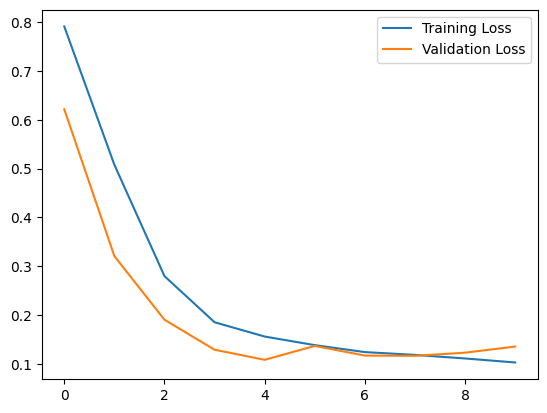

In [169]:
# Train AE model
history = ae.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=1,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)
p.plot(history.history["loss"], label="Training Loss")
p.plot(history.history["val_loss"], label="Validation Loss")
p.legend()
p.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x600 with 0 Axes>

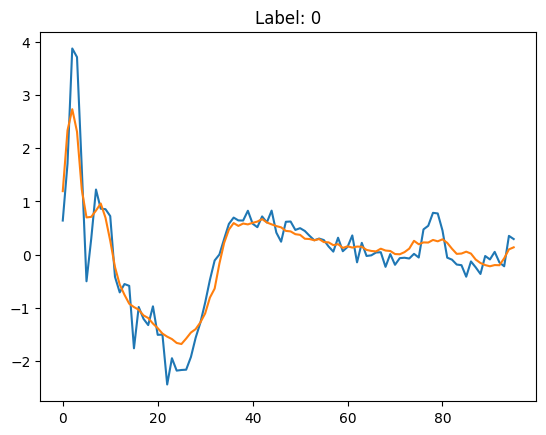

<Figure size 800x600 with 0 Axes>

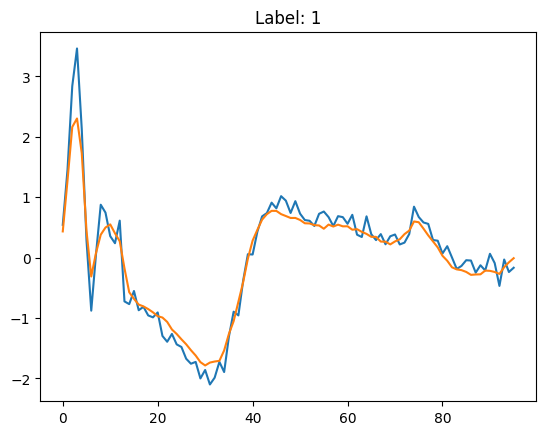

<Figure size 800x600 with 0 Axes>

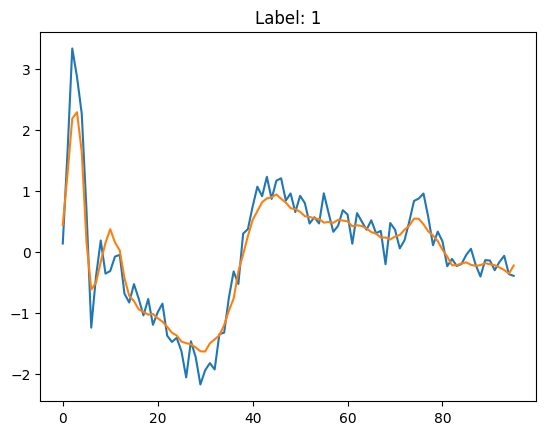

<Figure size 800x600 with 0 Axes>

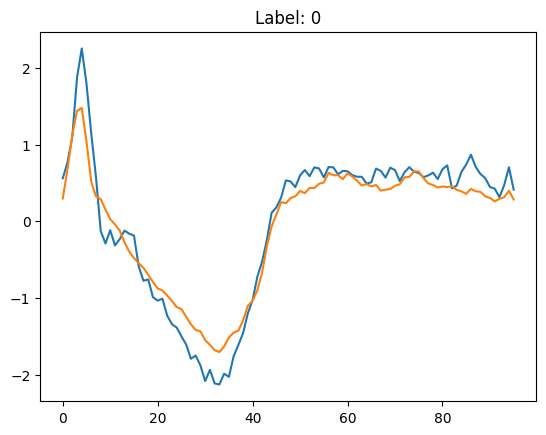

<Figure size 800x600 with 0 Axes>

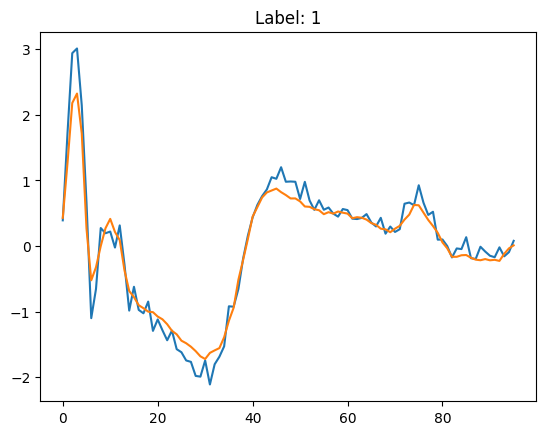

<Figure size 800x600 with 0 Axes>

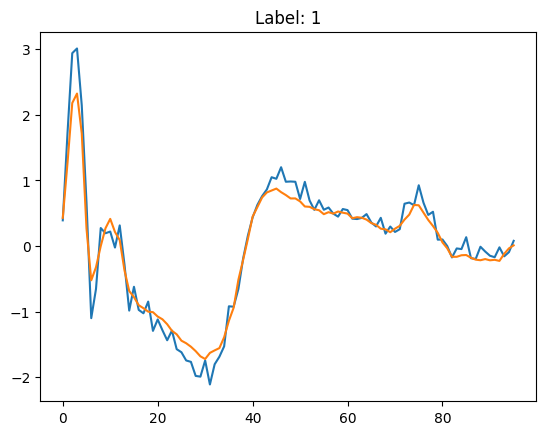

<Figure size 800x600 with 0 Axes>

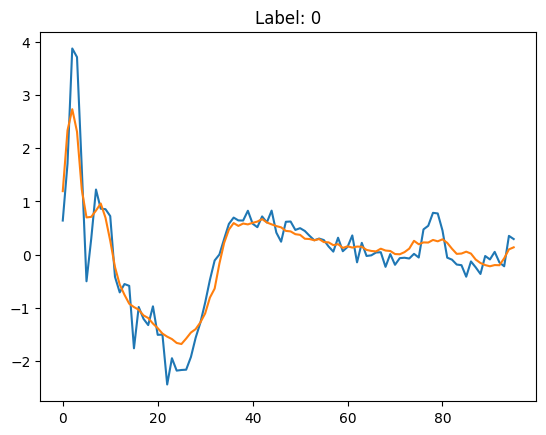

<Figure size 800x600 with 0 Axes>

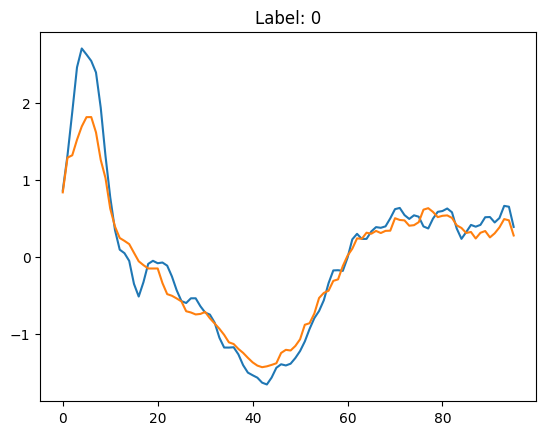

<Figure size 800x600 with 0 Axes>

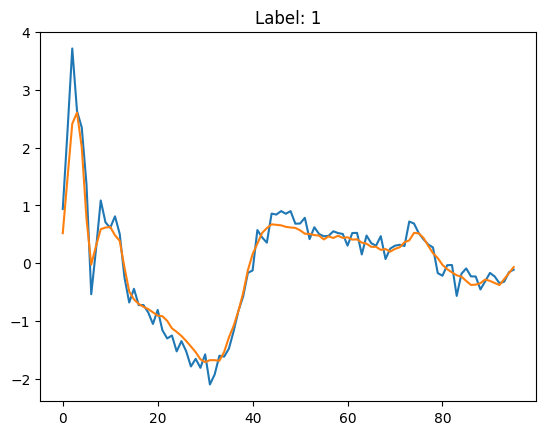

<Figure size 800x600 with 0 Axes>

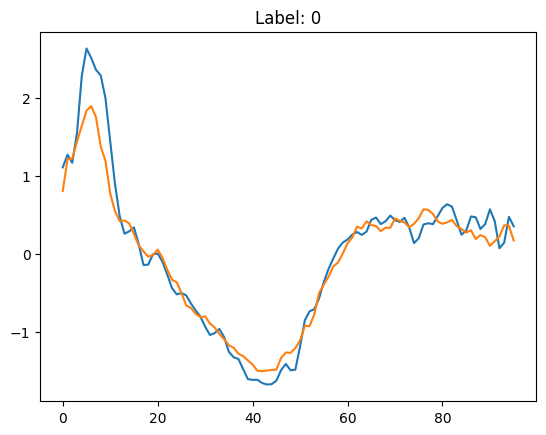

<Figure size 800x600 with 0 Axes>

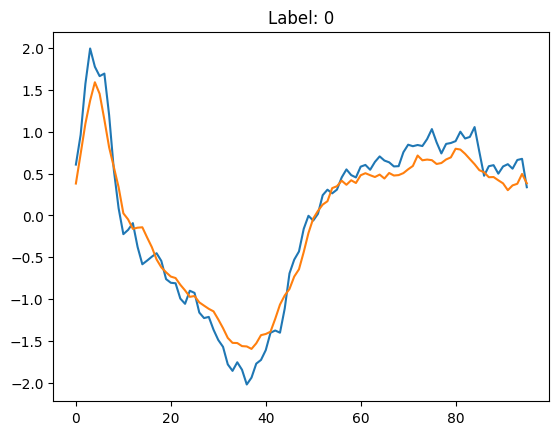

<Figure size 800x600 with 0 Axes>

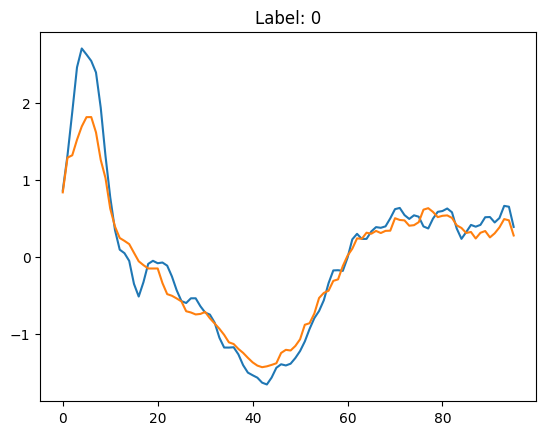

<Figure size 800x600 with 0 Axes>

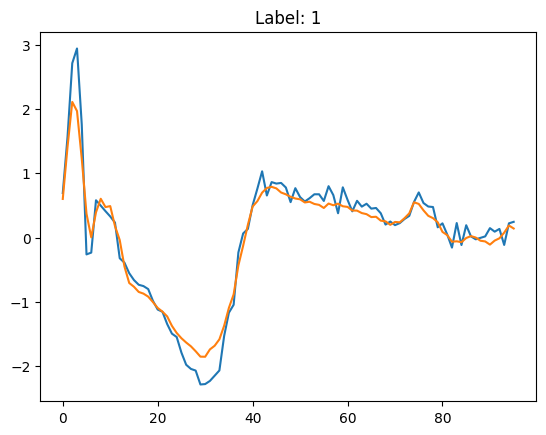

<Figure size 800x600 with 0 Axes>

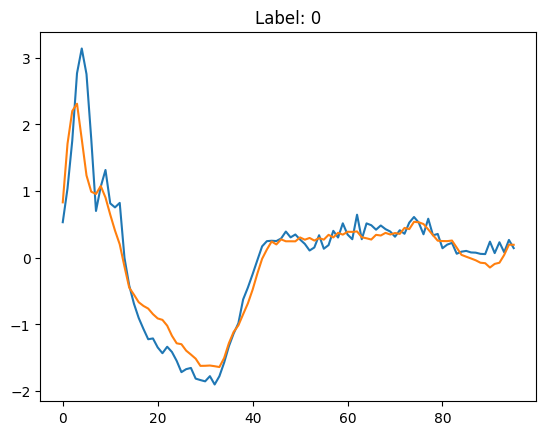

<Figure size 800x600 with 0 Axes>

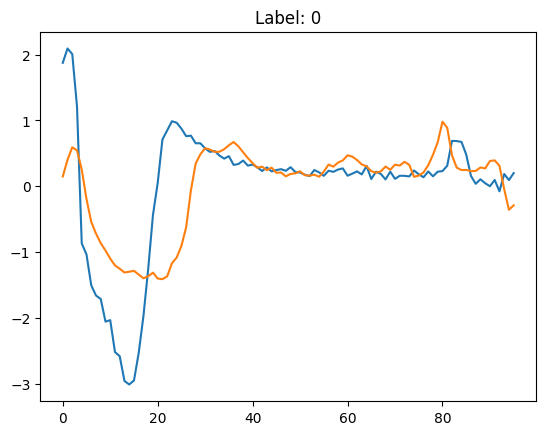

<Figure size 800x600 with 0 Axes>

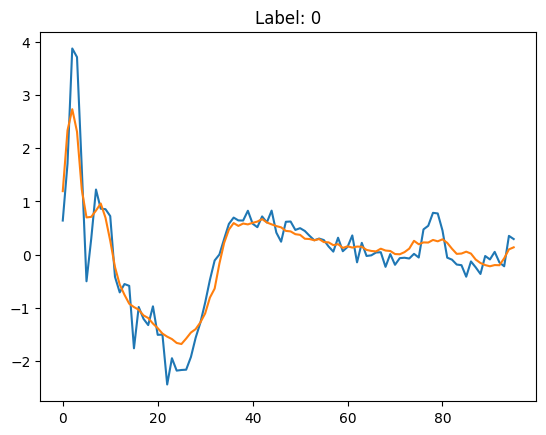

<Figure size 800x600 with 0 Axes>

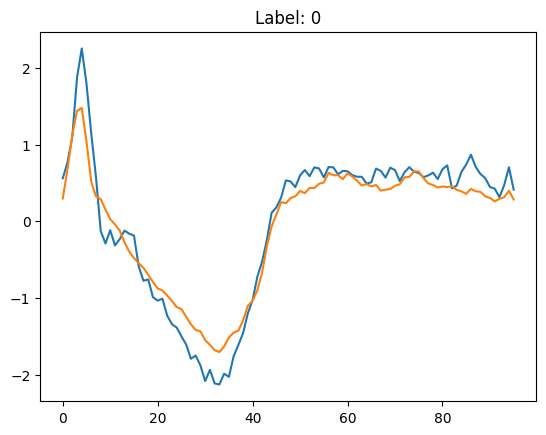

<Figure size 800x600 with 0 Axes>

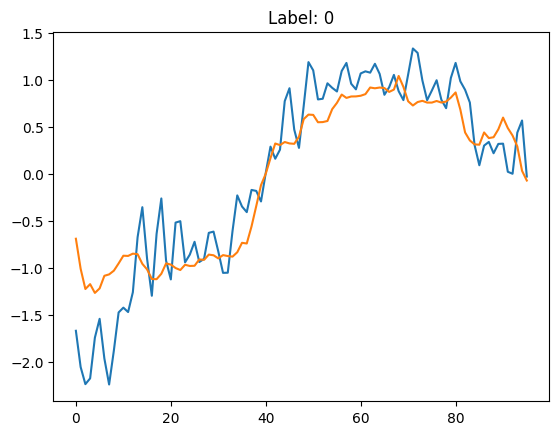

<Figure size 800x600 with 0 Axes>

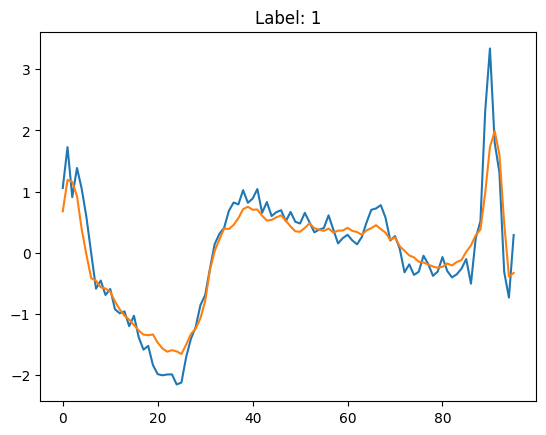

<Figure size 800x600 with 0 Axes>

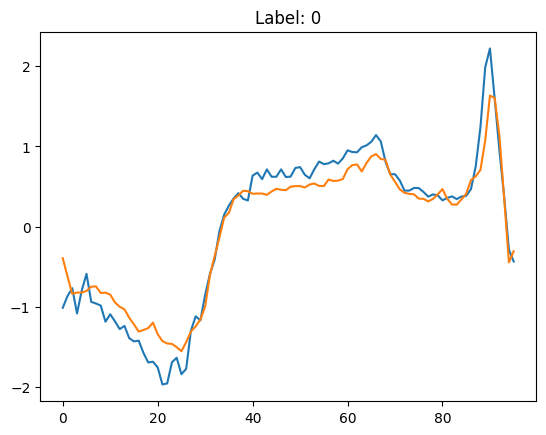

In [128]:
# Reconstruct X_test and plot reconstructions from x_test
X_test_reconst = ae.predict(X_test)
n_features = X_test.shape[2]
for i in np.random.choice(len(X_test), 20):
    fig = p.figure(figsize=(8, 6))
    f, axs = p.subplots(n_features, 1)
    if n_features == 1:
        axs = [axs]
    for j in range(n_features):
        axs[j].plot(list(range(X_test.shape[1])), X_test[i, :, j].flatten())
        axs[j].plot(list(range(X_test.shape[1])), X_test_reconst[i, :, j].flatten())
    p.title(f"Label: {y_test[i]}")
    p.show()

In [170]:
# Store keras model
ae.save(f'./{Dataset}_ae.keras')

# Create Outlier calculator and store it
outlier_calculator = AEOutlierCalculator(ae, X_train)
with open(f'./{Dataset}_outlier_calculator.pickle', 'wb') as f:
    pickle.dump(outlier_calculator, f, pickle.HIGHEST_PROTOCOL)

In [171]:
PREFIX_FILES_NAME = "subspace"

In [223]:
# DATASETS = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
DATASETS = ['ECG200']
MULTIPROCESSING = False
I_START = 0
THREAD_SAMPLES = 5
POOL_SIZE = 5


experiments = {
    'subspace': {
        'params': {
            'population_size': 10,
            'change_subseq_mutation_prob': 0.05,
            'elite_number': 2,
            'offsprings_number': 8,
            'max_iter': 3,
            'init_pct': 0.2,
            'reinit': True,
            'alpha': 0.2,
            'beta': 0.6,
            'eta': 0.2,
            'gamma': 0.25,
            'sparsity_balancer': 0.4,
        },
    },
}



for experiment_name, experiment_params in experiments.items():
    for Dataset in DATASETS:
        print(f'Starting experiment {experiment_name} for dataset {Dataset}...')
        experiment_dataset(
            Dataset,
            experiment_name,
            experiment_params["params"]
        )
print('Finished')

Starting experiment subspace for dataset ECG200...
Model loaded successfully
Predictions created successfully
Nuns created successfully
Sample completed 0
Sample completed 5
Sample completed 10
Sample completed 15
Sample completed 20
Sample completed 25
Sample completed 30
Sample completed 35
Sample completed 40
Sample completed 45
Sample completed 50
Sample completed 55
Sample completed 60
Sample completed 65
Sample completed 70
Sample completed 75
Sample completed 80
Sample completed 85
Sample completed 90
Sample completed 95
Starting experiment subspace for dataset ECG200...


  0%|          | 0/20 [00:00<?, ?it/s]

Using conv layer: conv1d_9


ValueError: The layer sequential_14 has never been called and thus has no defined output.

In [218]:
def calculate_heatmap(model, x_orig):
    # Dummy-Eingabe verwenden, um sicherzustellen, dass alle Schichten aufgerufen wurden
    dummy_input = np.expand_dims(x_orig, axis=0)
    _ = model(dummy_input)
    
    # Jetzt können wir die Layer-Ausgaben abrufen
    for layer in model.layers:
        if isinstance(layer, keras.Sequential) and layer.name == 'sequential_12':
            conv_layer_names = [sub_layer.name for sub_layer in layer.layers if 'conv1d' in sub_layer.name]
            if not conv_layer_names:
                raise ValueError("No conv1d layers found in sequential_12 model.")
            last_conv_layer = conv_layer_names[-1]
            print(f"Using conv layer: {last_conv_layer}")
            conv_layer = layer.get_layer(last_conv_layer)
            break
    else:
        raise ValueError("Layer sequential_12 not found in model.")

    # Create the heatmap using the identified layer
    heatmap_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(np.expand_dims(x_orig, axis=0))
                category_id = np.argmax(predictions[0])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1))
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num / alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=0)
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)
    deep_linearization_weights = np.sum(weights * alphas, axis=0)
    grad_cam_map = np.sum(deep_linearization_weights * conv_output[0], axis=1)
    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    # Expand heatmap
    expanded_heatmap = np.interp(np.linspace(0, 1, x_orig.shape[0]), np.linspace(0, 1, len(heatmap)), heatmap)
    expanded_heatmap = np.tile(expanded_heatmap.reshape(-1, 1), (1, x_orig.shape[1]))

    return expanded_heatmap
